<a href="https://colab.research.google.com/github/vicentegilso/clasificaciondeimagenes/blob/main/Finetuning_Faster_R_CNN_to_detect_Animated_Faces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Finetuning Faster R-CNN to detect Animated Faces
---
⚠️⚠️⚠️⚠️⚠️ **Big Disclaimer:** ⚠️⚠️⚠️⚠️⚠️

*This notebook is basically copied from [TorchVision 0.3 Object Detection finetuning tutorial](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html)*. 

*The original tutorial, explains ho to finetune a pre-trained Mask R-CNN (a very similar model to the one we'll use in here) on a segmentation task.*

*I recomend to take a look at the original tutorial. I won't cite each time that I have to reference the original tutorial because there are many parts borrowed.*

🔝🔝🔝 **All kudos to the torchvision team.** 🔝🔝🔝

---




So far we have seen that we have:
1. Models that work very well on Real Action Human Faces
2. Models capable of detecting things on Animated Content

**But**
1. We can't use models on Human Faces because the do not reconize Animated Characters
2. These methods fail when trying to retrain
3. Deep Learning models (like Faster R-CNN) can detect things, but Faces are not in its objective domain

**Option #1**

Train a Faster R-CNN from scratch.

⚠️  Problems ⚠️:
  1. We need a lot of data
  2. This data has to be annotated
  3. Anotation is hard and expensive

**Option #2**

Transfer Learning

We will reuse the pretrained network in order to detect other things that are not in the original domain.

👌 Visit Sebastian Ruder great [blogpost](https://ruder.io/transfer-learning/) about this topic. 💯💯💯

<p>

<img src="https://ruder.io/content/images/2017/03/transfer_learning_setup.png" alt="drawing" width="700"/>

✅ First, we need to install `pycocotools`. 

This library will be used for computing the evaluation metrics following the COCO metric for intersection over union.

In [ ]:
%%shell

pip install cython
# Install pycocotools, the version by default in Colab
# has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-1x7r_lxx
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-1x7r_lxx
  Created wheel for pycocotools: filename=pycocotools-2.0-cp37-cp37m-linux_x86_64.whl size=263898 sha256=adbff4239a50febeafdfab1cf229c04898a91fd83e686a2a108f0199768365eb
  Stored in directory: /tmp/pip-ephem-wheel-cache-lshlefzm/wheels/90/51/41/646daf401c3bc408ff10de34ec76587a9b3ebfac8d21ca5c3a
Successfully built pycocotools
  Found existing installation: pycocotools 2.0
    Uninstalling pycocotools-2.0:
      Successfully uninstalled pycocotools-2.0


# Brief note about finetuning and transfer learning
What are we going to do is to:
1. 🆗 Load a trained model
2. 🆕 Substitute a brand new *layer*
3. 🆒 Train this layer to identify new objects (in our case faces)

You can see this new layer that we are going to add as a blank canvas that we have to *retrain*.

💤💤💤💤💤💤💤💤💤💤

In the process of retraining we will have to have a **dataset** and the **load the dataset** to feed the model.

One of the main features of the PyTorch framework is the support for building the dataset and making the access to data easy and smooth.

We will use two important classes `Dataset` and `Dataloader`:
* `Dataset` will let us to define a group of instances with custom properties and methods
* `Dataloader` will iteratively and efficiently feed the model with data from the dataset

## The Data used

To do this task we will use data from the [iQIYI iCartoonFace Challenge](http://challenge.ai.iqiyi.com/detail?raceId=5def71b4e9fcf68aef76a75e). 

The iCartoonFace detection dataset is a large-scale dataset established for cartoon face detection, which contains multiple styles.

It contains images from Animated Content labeled with bounding boxes around faces.

## Defining the Dataset

The [torchvision reference scripts for training object detection, instance segmentation and person keypoint detection](https://github.com/pytorch/vision/tree/v0.3.0/references/detection) allows for easily supporting adding new custom datasets.

The dataset should inherit from the standard `torch.utils.data.Dataset` class, and implement `__len__` and `__getitem__`.

The only specificity that we require is that the dataset `__getitem__` should return:

* image: a PIL Image of size (H, W)
* target: a dict containing the following fields
    * `boxes` (`FloatTensor[N, 4]`): the coordinates of the `N` bounding boxes in `[x0, y0, x1, y1]` format, ranging from `0` to `W` and `0` to `H`
    * `labels` (`Int64Tensor[N]`): the label for each bounding box
    * `image_id` (`Int64Tensor[1]`): an image identifier. It should be unique between all the images in the dataset, and is used during evaluation
    * `area` (`Tensor[N]`): The area of the bounding box. This is used during evaluation with the COCO metric, to separate the metric scores between small, medium and large boxes.
    * `iscrowd` (`UInt8Tensor[N]`): instances with `iscrowd=True` will be ignored during evaluation.
    * (optionally) `masks` (`UInt8Tensor[N, H, W]`): The segmentation masks for each one of the objects
    * (optionally) `keypoints` (`FloatTensor[N, K, 3]`): For each one of the `N` objects, it contains the `K` keypoints in `[x, y, visibility]` format, defining the object. `visibility=0` means that the keypoint is not visible. Note that for data augmentation, the notion of flipping a keypoint is dependent on the data representation, and you should probably adapt `references/detection/transforms.py` for your new keypoint representation

If your model returns the above methods, they will make it work for both training and evaluation, and will use the evaluation scripts from pycocotools.


Before moving forward we will load some functions that will make our life easier

In [ ]:
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw 
import numpy as np
from pathlib import Path
from tqdm.notebook import tqdm

# old good friends never die ;-)
def my_draw_rectangle(draw, coordinates, color, width=1):
    for i in range(width):
        rect_start = (coordinates[0][0] - i, coordinates[0][1] - i)
        rect_end = (coordinates[1][0] + i, coordinates[1][1] + i)
        draw.rectangle((rect_start, rect_end), outline = color)
        
def draw_rectangle(img, boundingBox):
    draw = ImageDraw.Draw(img)
    np_img = np.array(img)
    x1, y1 = boundingBox[0], boundingBox[1]
    x2, y2 = boundingBox[2], boundingBox[3]
    my_draw_rectangle(
        draw, 
        ((x1,y1), (x2, y2)), 
        "green", 
        int((np_img.shape[0])/100)
      )
    return img

def add_text(img, bbox, label):
  draw = ImageDraw.Draw(img)
  # font = ImageFont.truetype(<font-file>, <font-size>)
  # font = ImageFont.truetype(font=ImageFont.load_default().font,size=16)
  font = ImageFont.load_default()
  x, y = bbox[0], bbox[1]
  w, h = font.getsize(label)
  y = y - h
  draw.rectangle((x - h*0.20, y, x + w, y + h), fill='green')
  draw.text((x, y), label, (255,255,255), font=font)
  return img

# we modified a little bit this function to handle multiple objects and probabilities
def draw_objects(img, object_bbox, object_labels, object_porbs, threshold=0.5, show_probs=False):
  for bbox, label, prob in zip(object_bbox, object_labels, object_porbs):
    if prob > threshold:
      img = draw_rectangle(img, bbox)
      if show_probs:
        label = '{} ({:.2f}%)'.format(label, prob*100)
      img = add_text(img, bbox, label)
  display(img)

### Writing a custom dataset for iQIYI iCartoonFace

Let's write a dataset for the iQIYI iCartoonFac dataset.

First, let's download and extract the data, present in a zip file at https://storage.googleapis.com/cartoon_face_recognition_workshop/personai_icartoonface_small.zip

In [ ]:
%%shell

# download the dataset
wget https://storage.googleapis.com/cartoon_face_recognition_workshop/personai_icartoonface_dettrain_lite.zip .
# extract it in the current folder
unzip personai_icartoonface_dettrain_lite.zipaaa 

Let's have a look at the dataset and how it is layed down.

The data is structured as follows
```
personai_icartoonface_dettrain_lite/
  icartoonface_dettrain.csv
  icartoonface_dettrain/
    personai_icartoonface_dettrain_00624.jpg
    personai_icartoonface_dettrain_00620.jpg
    personai_icartoonface_dettrain_00619.jpg
    personai_icartoonface_dettrain_00609.jpg
    personai_icartoonface_dettrain_00608.jpg
    personai_icartoonface_dettrain_00593.jpg
    ...
```

The `.csv` file contains the bounding boxes for all the images. So to load the annotaion we have to pick the image name and find the line in the file corresponding to the image.

Here is one example of an image in the dataset, with its bounding box

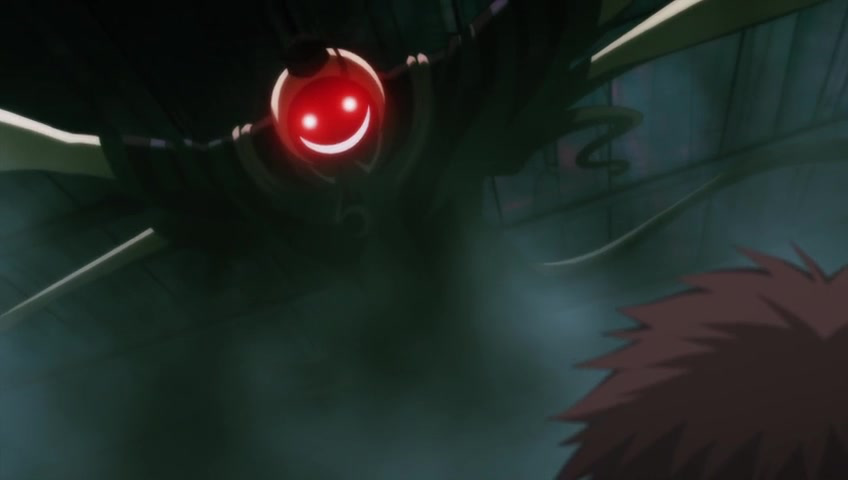

In [ ]:
from PIL import Image
Image.open('personai_icartoonface_dettrain_lite/icartoonface_dettrain/personai_icartoonface_dettrain_08322.jpg')

In [ ]:
import pandas as pd
from collections import defaultdict

def load_csv_as_dict(csv_path, image_path):
  '''
    Loads the csv file as a dict, so we can access the 
    bounding boxes as dict()[filename] -> bbox
    As we might want to work with smaller datasets we 
    can filter these available Images in image_path
  '''
  bboxes_dict = defaultdict(list)
  with open(csv_path, 'r') as f:
    csv_lines = f.readlines()

  filenames = [fname.name for fname in Path(image_path).glob('*')]
  for l in tqdm(csv_lines):
    csv_row = l.strip('/n').split(',')
    if csv_row[0] in filenames:
      bboxes_dict[csv_row[0]].append([int(coord) for coord in csv_row[1:]])

  return bboxes_dict

In [ ]:
img = Image.open('personai_icartoonface_dettrain_lite/icartoonface_dettrain/personai_icartoonface_dettrain_08322.jpg')
bbox_dict = load_csv_as_dict(
    'personai_icartoonface_dettrain_lite/icartoonface_dettrain.csv',
    'personai_icartoonface_dettrain_lite/icartoonface_dettrain'
    )

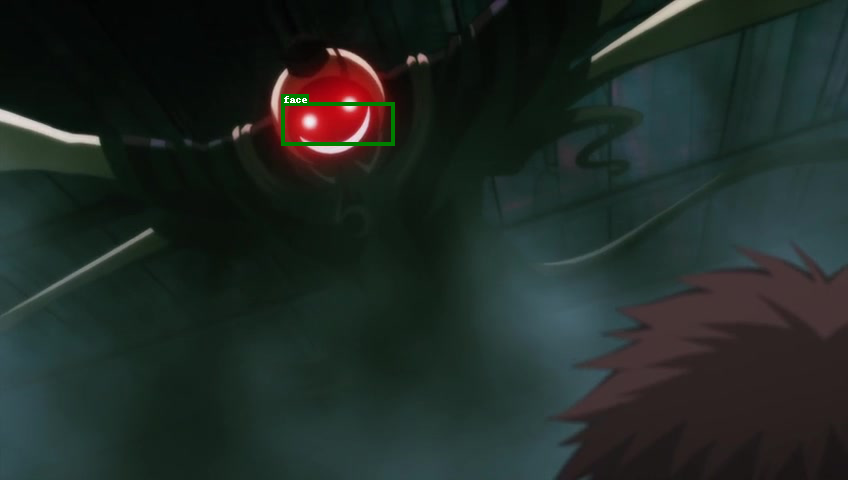

In [ ]:
face_bbox = bbox_dict['personai_icartoonface_dettrain_08322.jpg']
draw_objects(img, face_bbox, ['face'], [1])

Let's write a `torch.utils.data.Dataset` class for this dataset.

In [ ]:
import os
import numpy as np
import torch
import torch.utils.data

class ICartoonFaceDataset(torch.utils.data.Dataset):
    def __init__(self, root, bbox_dict, transforms=None):
        self.root = root
        self.bbox_dict = bbox_dict
        self.transforms = transforms
        self.imgs = [
                     Path(self.root)/fname for fname in tqdm(
                         list(self.bbox_dict.keys())
                         )
                     ]


    def __getitem__(self, idx):
        # we will get an identifier as idx
        # load images and boxes using idx
        img = Image.open(self.imgs[idx]).convert("RGB")
        # we get the iamge name
        image_name = Path(self.imgs[idx]).name
        # and use the image name to get the bbox_list from the csb
        bbox_list = self.bbox_dict[image_name]
        # convert to tensor
        boxes = torch.as_tensor(bbox_list, dtype=torch.float32)

        # define labels
        num_objs = boxes.shape[0]
        # there is only one class so we use a list of ones
        labels = torch.ones((num_objs,), dtype=torch.int64)
        image_id = torch.tensor([idx])

        # needed for suport with standard methods
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd (not used)
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["image_id"] = image_id
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd
        
        # we might want to transform the data
        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

That's all for the dataset. Let's see how the outputs are structured for this dataset

In [ ]:
dataset = ICartoonFaceDataset(
    root='personai_icartoonface_dettrain_lite/icartoonface_dettrain/',
    bbox_dict=bbox_dict
)
dataset[0]

(<PIL.Image.Image image mode=RGB size=848x480 at 0x7F25586C8E90>,
 {'area': tensor([3816., 1360.]), 'boxes': tensor([[440., 346., 512., 399.],
          [181., 243., 215., 283.]]), 'image_id': tensor([0]), 'iscrowd': tensor([0, 0]), 'labels': tensor([1, 1])})

In [ ]:
len(dataset.imgs)

590

So we can see that by default, the dataset returns a `PIL.Image` and a dictionary
containing several fields, including `boxes` and `labels`.

## Defining your model

The original tutorial, used [Mask R-CNN](https://arxiv.org/abs/1703.06870), which is based on top of [Faster R-CNN](https://arxiv.org/abs/1506.01497). 

* Faster R-CNN is a model that predicts both **bounding boxes** and **class scores** for potential objects in the image.

<img src="https://raw.githubusercontent.com/pytorch/vision/temp-tutorial/tutorials/tv_image03.png" alt="drawing" width="700"/>

* Mask R-CNN adds an extra branch into Faster R-CNN, which also predicts segmentation masks for each instance.

<img src="https://raw.githubusercontent.com/pytorch/vision/temp-tutorial/tutorials/tv_image04.png" alt="drawing" width="700"/>

There are two common situations where one might want to modify one of the available models in torchvision modelzoo.

* The first is when we want to start from a pre-trained model, and just finetune the last layer. 

* The other is when we want to replace the backbone of the model with a different one (for faster predictions, for example). **We won't cover this one**

Let's go see how we would do the first option.


### 1 - Finetuning from a pretrained model

Let's suppose that you want to start from a model pre-trained on COCO and want to finetune it for your particular classes. Here is a possible way of doing it:
```
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (person) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 
```



That's it, this will make model be ready to be trained and evaluated on our custom dataset.

## Training and evaluation functions

For me, evaluating a detection model is not intuitive, and there are a series of metrics defined to check how the model is performing. We do not have the time to cover it here, but you can dig a little bit more [here](https://blog.zenggyu.com/en/post/2018-12-16/an-introduction-to-evaluation-metrics-for-object-detection/).

In the Torchvision official repository there are a lot of handy tools to make the process of training and evaluation easier for the user.

Going to https://github.com/pytorch/vision.git and the `references/detection/,` there are a number of helper functions to simplify training and evaluating detection models.

Here, we will use `references/detection/engine.py`, `references/detection/utils.py` and `references/detection/transforms.py`.

Let's copy those files (and their dependencies) in here so that they are available in the notebook

In [ ]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

fatal: destination path 'vision' already exists and is not an empty directory.
HEAD is now at be376084 version check against PyTorch's CUDA version




Let's write some helper functions for data augmentation / transformation, which leverages the functions in `refereces/detection` that we have just copied:


In [ ]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

Basically the transformation do the following:
* `T.ToTensor()` transform the data into tensors so it can be feed into the model
* `T.RandomHorizontalFlip(0.5)` randomly (with 0.5 chance) flip the input image (and labels) so the model learn to detect images even upside down

### Putting everything together

We now have the dataset class, the models and the data transforms. 

Next we will put our `ICartoonFaceDataset` in a `torch.utils.data.DataLoader`. 

This `Dataloader` is an iterable structure that will feed the model in batches. It has the property to run in parallel, so we can avoid the bottleneck between the CPU and the GPU.

We will add one last thing: a test dataset. Once done we're ready to gol

Let's instantiate them

In [ ]:
# split bbox_dict into test and train
all_keys = list(bbox_dict.keys())

train_keys = all_keys[:int(len(all_keys)*0.8)]
test_keys = all_keys[int(len(all_keys)*0.8):]

# to be used later (we will come back here)
train_keys = train_keys[:100]
test_keys = test_keys[:30]

bbox_dict_train = {k: bbox_dict[k] for k in train_keys}
bbox_dict_test = {k: bbox_dict[k] for k in test_keys}

# use our dataset and defined transformations
dataset = ICartoonFaceDataset(
    root='personai_icartoonface_dettrain_lite/icartoonface_dettrain/',
    bbox_dict=bbox_dict_train,
    transforms=get_transform(train=True)
)

dataset_test = ICartoonFaceDataset(
    root='personai_icartoonface_dettrain_lite/icartoonface_dettrain/',
    bbox_dict=bbox_dict_test,
    transforms=get_transform(train=False)
)

data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Now let's instantiate the model and the optimizer

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# get the model using our helper function
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
num_classes = 2
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

And now let's train the model for 10 epochs, evaluating at the end of every epoch.

In [ ]:
# let's train it for 10 epochs
# num_epochs = 10
num_epochs = 2
print_freq = 20 

for epoch in range(num_epochs):
    # train for one epoch, printing every print_freq iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=print_freq)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: [0]  [  0/236]  eta: 0:03:58  lr: 0.000026  loss: 1.5240 (1.5240)  loss_classifier: 0.5354 (0.5354)  loss_box_reg: 0.3668 (0.3668)  loss_objectness: 0.5812 (0.5812)  loss_rpn_box_reg: 0.0407 (0.0407)  time: 1.0096  data: 0.2968  max mem: 3946
Epoch: [0]  [ 20/236]  eta: 0:02:27  lr: 0.000451  loss: 0.4245 (0.5862)  loss_classifier: 0.2210 (0.3237)  loss_box_reg: 0.1068 (0.1506)  loss_objectness: 0.0721 (0.0934)  loss_rpn_box_reg: 0.0093 (0.0185)  time: 0.6653  data: 0.0082  max mem: 3946
Epoch: [0]  [ 40/236]  eta: 0:02:12  lr: 0.000876  loss: 0.3459 (0.4989)  loss_classifier: 0.1547 (0.2535)  loss_box_reg: 0.1667 (0.1674)  loss_objectness: 0.0280 (0.0627)  loss_rpn_box_reg: 0.0077 (0.0152)  time: 0.6724  data: 0.0088  max mem: 4123
Epoch: [0]  [ 60/236]  eta: 0:01:57  lr: 0.001302  loss: 0.3326 (0.4540)  loss_classifier: 0.1244 (0.2157)  loss_box_reg: 0.1551 (0.1711)  loss_objectness: 0.0239 (0.0539)  loss_rpn_box_reg: 0.0082 (0.0133)  time: 0.6515  data: 0.0082  max mem: 4123


Now that training has finished, let's have a look at what it actually predicts in a test image

In [ ]:
# pick one image from the test set
img, _ = dataset_test[0]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    output = model([img.to(device)])

Printing the prediction shows that we have a list of dictionaries. 

Each element of the list corresponds to a different image. 

As we have a single image, there is a single dictionary in the list.


The dictionary contains the predictions for the image we passed. In this case, we can see that it contains `boxes`, `labels`, and `scores` as fields.

In [ ]:
# convert bounding boxes to a list of coordinates
bboxes = output[0]['boxes'].cpu().numpy().tolist()
# convert label index to strings
labels = ['face' for l in output[0]['labels'].cpu().numpy().tolist()]
# convert scores to list
probs = output[0]['scores'].cpu().numpy().tolist()

Let's inspect the image and the predicted bounding boxes.

For that, we need to convert the image, which has been rescaled to 0-1 and had the channels flipped so that we have it in `[C, H, W]` format.

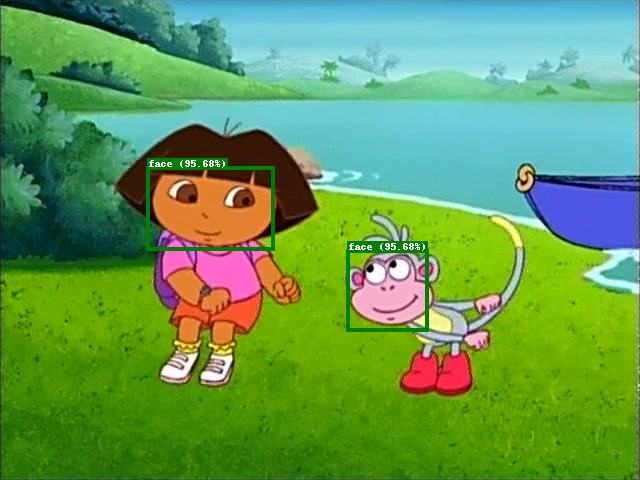

In [ ]:
np_img = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
draw_objects(np_img, bboxes, labels, probs, threshold=0.3, show_probs=True)

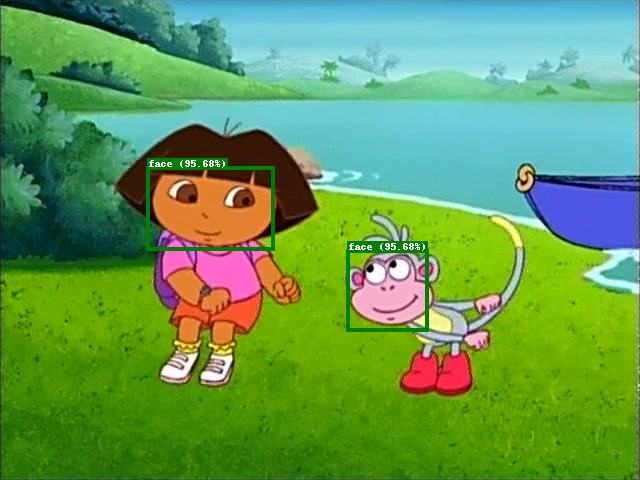

In [ ]:
np_img = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
draw_objects(np_img, bboxes, labels, probs, threshold=0.5, show_probs=True)

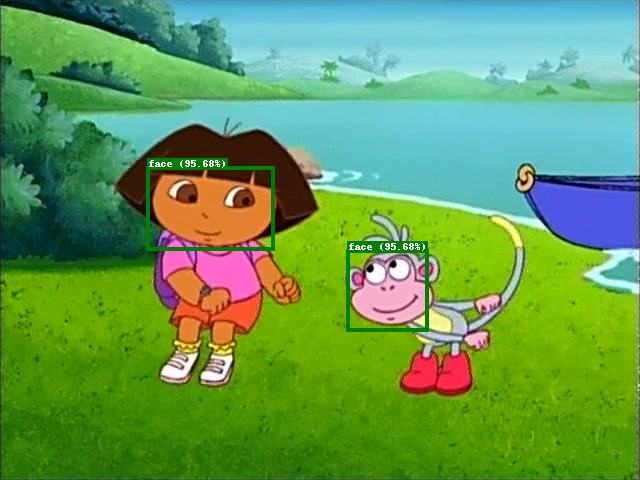

In [ ]:
np_img = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
draw_objects(np_img, bboxes, labels, probs, threshold=0.85, show_probs=True)

Looks pretty good!

## Conclusions
* In this tutorial we learned how to create our pipeline to train an object detection model
* We have seen that withou a lot of effort we can build a model that seems to do start doing interesting things
* We need to train longer to see how far it can go to the task of detecting faces